In [1]:
import os
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import wandb

In [2]:
train_data_path = r"F:\PAST\HUST\IT-E10\Introduction to AI\Intro2AI\train"
train_label_path = r"F:\PAST\HUST\IT-E10\Introduction to AI\Intro2AI\train_label.csv"
train_labels = pd.read_csv(train_label_path)
train_dict = train_labels.to_dict(orient="records")

In [3]:
class TrainImageDataset(Dataset):
    def __init__(self, data_dict, input_path, transform=None):
        self.data_dict = data_dict
        self.input_path = input_path
        self.transform = transform

    def __len__(self):
        return len(self.data_dict)

    def __getitem__(self, idx):
        img_name = self.data_dict[idx]['image_name']
        label = self.data_dict[idx]['label']

        img_path = os.path.join(self.input_path, img_name)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
#BATCH_SIZE = 8
#train_dataset = TrainImageDataset(data_dict=train_dict, input_path=train_data_path, transform=transform)
#train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
BATCH_SIZE = 8

# Create full dataset
full_dataset = TrainImageDataset(data_dict=train_dict, input_path=train_data_path, transform=transform)

# Split dataset into train (70%) and test (30%)
from torch.utils.data import random_split

train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Total samples: {len(full_dataset)}")
print(f"Train samples (70%): {len(train_dataset)}")
print(f"Test samples (30%): {len(test_dataset)}")

# Create dataloaders with drop_last=True to avoid BatchNorm issues with batch size 1
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Total samples: 654
Train samples (70%): 457
Test samples (30%): 197


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  
NUM_CLASSES = 15

Using device: cuda


In [8]:
# !!! Do not change anything of this cell !!!
from torch import Tensor
from typing import Type

class BasicBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None,
    ) -> None:
        super(BasicBlock, self).__init__()

        self.expansion = expansion
        self.downsample = downsample
        self.conv1_layer = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )

        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2_layer = nn.Conv2d(
            out_channels,
            out_channels * self.expansion,
            kernel_size=3,
            padding=1,
            bias=False,
        )

        self.batch_norm2 = nn.BatchNorm2d(out_channels * self.expansion)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1_layer(x)
        out = self.batch_norm1(out)
        out = self.relu(out)

        out = self.conv2_layer(out)
        out = self.batch_norm2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class CNN(nn.Module): #ResNet18
    def __init__(
        self,
        block: Type[BasicBlock],
        img_channels: int = 3,
        num_classes: int = 10,
    ) -> None:
        super(CNN, self).__init__()
        layers = [2, 2, 2, 2]
        self.expansion = 1

        self.in_channels = 64

        self.conv_layer = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.batch_norm = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool_layer = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer_1 = self._make_layer(block, 64, layers[0])
        self.layer_2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer_3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer_4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool_layer = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_layer = nn.Linear(512 * self.expansion, num_classes)

    def _make_layer(
        self, block: Type[BasicBlock], out_channels: int, blocks: int, stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, self.expansion, downsample)
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, blocks):
            layers.append(
                block(self.in_channels, out_channels, expansion=self.expansion)
            )
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv_layer(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.maxpool_layer(x)

        c2 = self.layer_1(x)
        c3 = self.layer_2(c2)
        c4 = self.layer_3(c3)
        c5 = self.layer_4(c4)

        x = self.avgpool_layer(c5)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)

        return x

In [9]:
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        # Channel Attention Components
        self.ca_avg = nn.AdaptiveAvgPool2d(1)
        self.ca_max = nn.AdaptiveMaxPool2d(1)
        self.ca_fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.ca_relu = nn.ReLU()
        self.ca_fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        # Spatial Attention Components
        self.sa_conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)

    def forward(self, x):
        # Channel Attention
        avg_out = self.ca_fc2(self.ca_relu(self.ca_fc1(self.ca_avg(x))))
        max_out = self.ca_fc2(self.ca_relu(self.ca_fc1(self.ca_max(x))))
        x = x * self.sigmoid(avg_out + max_out)
        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        sa_map = self.sigmoid(self.sa_conv(torch.cat([avg_out, max_out], dim=1)))
        return x * sa_map, sa_map

In [10]:
class AuxiliaryHead(nn.Module):
    def __init__(self, in_channels=2048, num_classes=15):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.avgpool(x).flatten(1)
        return self.fc(x)

In [11]:
class GridMaskSelector(nn.Module):
    """Responsible for logic: 3x3 Grid -> Select Best 2x2 Square -> Create Mask"""
    def __init__(self, grid_size=3):
        super().__init__()
        self.grid_size = grid_size 

    def forward(self, attention_map, input_img):
        B, _, H, W = input_img.shape
        # 1. Downsample to grid
        grid_att = F.adaptive_avg_pool2d(attention_map, (self.grid_size, self.grid_size))
        
        # 2. Find best 2x2 window
        with torch.no_grad():
            kernel = torch.ones((1, 1, 2, 2)).to(attention_map.device)
            sum_att = F.conv2d(grid_att, kernel, stride=1).view(B, -1)
            best_idx = torch.argmax(sum_att, dim=1)

        # 3. Create Mask
        mask = torch.zeros((B, 1, H, W)).to(input_img.device)
        h_step, w_step = H // self.grid_size, W // self.grid_size
        
        for b in range(B):
            idx = best_idx[b].item()
            r, c = (idx // 2), (idx % 2)
            mask[b, :, r*h_step:(r+2)*h_step, c*w_step:(c+2)*w_step] = 1.0

        return input_img * (1 - mask), mask

In [12]:
class ResNetBackbone6Layers(CNN):
    """6-layer backbone built on top of CNN while preserving the original spatial/channel logic."""
    def __init__(self, block, img_channels=3):
        # Reuse CNN stem and first 4 layers
        super().__init__(block=block, img_channels=img_channels, num_classes=1)  # num_classes unused here
        
        # Force spatial size to 96x96 after the stem (replace prior maxpool effect)
        self.force_spatial_96 = nn.AdaptiveAvgPool2d((96, 96))
        
        self.in_channels = 512  # state after layer_4 in the parent
        self.layer_5 = self._make_layer(block, 1024, blocks=2, stride=2)  
        self.layer_6 = self._make_layer(block, 2048, blocks=2, stride=2)  
        
        self._init_new_layers()
        
    def _init_new_layers(self):
        # Initialize only the newly added layers to match prior custom init
        for m in [self.layer_5, self.layer_6]:
            for sub in m.modules():
                if isinstance(sub, nn.Conv2d):
                    nn.init.kaiming_normal_(sub.weight, mode='fan_out', nonlinearity='relu')
                elif isinstance(sub, nn.BatchNorm2d):
                    nn.init.constant_(sub.weight, 1)
                    nn.init.constant_(sub.bias, 0)
        
    def forward(self, x):
        # Stem: conv7x7 stride2 -> BN/ReLU -> force to 96x96
        x = self.conv_layer(x)            # [B, 64, 112, 112]
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.force_spatial_96(x)     # [B, 64, 96, 96]
        
        # Shared CNN layers 1-4
        c1 = self.layer_1(x)              # [B, 64, 96, 96]
        c2 = self.layer_2(c1)            # [B, 128, 48, 48]
        c3 = self.layer_3(c2)            # [B, 256, 24, 24]
        c4 = self.layer_4(c3)            # [B, 512, 12, 12]
        
        # Extra layers 5-6
        c5 = self.layer_5(c4)            # [B, 1024, 6, 6]
        c6 = self.layer_6(c5)            # [B, 2048, 3, 3]
        
        return [c1, c2, c3, c4], c6

In [13]:
class FPN(nn.Module):
    def __init__(self, in_channels_list=[64, 128, 256, 512], out_channels=256):
        super().__init__()
        self.lateral = nn.ModuleList([nn.Conv2d(c, out_channels, 1) for c in in_channels_list])
        self.smooth = nn.Conv2d(out_channels, out_channels, 3, padding=1)

    def forward(self, features):
        c2, c3, c4, c5 = features
        # Top-down pathway
        p5 = self.lateral[3](c5)
        p4 = self.lateral[2](c4) + F.interpolate(p5, scale_factor=2)
        p3 = self.lateral[1](c3) + F.interpolate(p4, scale_factor=2)
        p2 = self.lateral[0](c2) + F.interpolate(p3, scale_factor=2)
        return [p2, p3, p4, p5]

In [14]:
class SharedFC(nn.Module):
    def __init__(self, in_channels=256, latent_dim=512):
        super().__init__()
        
        # Encoder CNN: Nén FPN to nhất (96x96x256) xuống nhỏ hơn để vào FC
        # Input: [B, 256, 96, 96]
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, stride=2, padding=1), # 96 -> 48
            nn.BatchNorm2d(256), nn.ReLU(),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 48 -> 24
            nn.BatchNorm2d(512), nn.ReLU(),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1), # 24 -> 12
            nn.BatchNorm2d(512), nn.ReLU(),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1), # 12 -> 6
            nn.BatchNorm2d(512), nn.ReLU(),
        )
        
        # [512, 6, 6]
        self.flatten_dim = 512 * 6 * 6 
        
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 1024),
            nn.BatchNorm1d(1024), nn.ReLU(inplace=True),
            nn.Linear(1024, latent_dim),
            nn.BatchNorm1d(latent_dim), nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        return self.fc_block(x)

In [15]:
class MainClassificationHead(nn.Module):
    def __init__(self, latent_dim=512, num_classes=15):
        super().__init__()
        self.fc = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

In [16]:
class ReconstructionHead(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        # Bung latent ra thành feature map để ConvTranspose
        self.fc_expand = nn.Linear(latent_dim, 512 * 7 * 7) 
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, 7, 7)),
            # Upsample dần lên 224x224
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # -> 14
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # -> 28
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  nn.BatchNorm2d(64),  nn.ReLU(), # -> 56
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   nn.BatchNorm2d(32),  nn.ReLU(), # -> 112
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    nn.Sigmoid()                    # -> 224
        )

    def forward(self, latent):
        x = self.fc_expand(latent)
        return self.decoder(x)

In [17]:
class MaskedAutoencoderSystem(nn.Module):
    def __init__(self, num_classes=15):
        super().__init__()
        self.backbone = ResNetBackbone6Layers(BasicBlock)
        
        # 2. FPN & CBAM & Selector
        self.fpn = FPN(in_channels_list=[64, 128, 256, 512], out_channels=256)
        self.cbam = CBAM(in_planes=2048)
        self.mask_selector = GridMaskSelector(grid_size=3)
        
        self.aux_head = AuxiliaryHead(in_channels=2048, num_classes=num_classes)
        
        # Shared FC: Nhận từ FPN (256 ch)
        self.shared_fc = SharedFC(in_channels=256, latent_dim=512)
        
        # Main Head & Rec Head: Nhận từ Shared FC (Latent 512)
        self.main_head = MainClassificationHead(latent_dim=512, num_classes=num_classes)
        self.rec_head = ReconstructionHead(latent_dim=512)

    def forward(self, x, training_mode=True):
        # PHASE 1: CLEAN PASS
        fpn_feats, final_feat = self.backbone(x) # fpn_feats = [c1, c2, c3, c4], final_feat = c6
        # Tính toán FPN
        fpn_outs = self.fpn(fpn_feats) 
        # fpn_outs[0] là lớp to nhất (tương ứng c1: 96x96)
        largest_fpn_feat = fpn_outs[0] 
        # CBAM (cho Aux Loss & Mask Selector)
        feat_att, att_map = self.cbam(final_feat)
        
        # --- Output 1: Aux Logits (Từ CBAM) ---
        aux_logits = self.aux_head(feat_att)
        # --- Output 2: Main Logits (Từ FPN to nhất -> Shared FC) ---
        clean_latent = self.shared_fc(largest_fpn_feat)
        main_logits = self.main_head(clean_latent)
        
        
        # PHASE 2: MASKED PASS
        rec_img, mask = None, None
        if training_mode:
            masked_x, mask = self.mask_selector(att_map.detach(), x) #detach() tạo nhánh mới, không truyền gradient
            
            # Cần chạy cả FPN vì SharedFC giờ đây yêu cầu output của FPN
            m_fpn_feats, _ = self.backbone(masked_x)
            m_fpn_outs = self.fpn(m_fpn_feats)
            
            # Lấy feature map to nhất của ảnh bị mask
            m_largest_fpn_feat = m_fpn_outs[0] 
            
            masked_latent = self.shared_fc(m_largest_fpn_feat)
            rec_img = self.rec_head(masked_latent)
            
        return {
            "aux_logits": aux_logits,
            "main_logits": main_logits,
            "rec_img": rec_img,
            "mask": mask
        }

In [18]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, device, lr=1e-3, save_interval=None, checkpoint_dir="checkpoints"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        
        # Trọng số cho các loss (Hyperparameters)
        self.lambda_aux = 0.4  # Aux loss thường có trọng số nhỏ hơn main
        self.lambda_rec = 0.5  # Reconstruction loss
        self.lr = lr
        
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.cls_criterion = nn.CrossEntropyLoss()
        
        # Checkpoint settings
        self.save_interval = save_interval  # Lưu mỗi N epochs, None = không tự động lưu
        self.checkpoint_dir = checkpoint_dir
        
        # Tạo thư mục checkpoint nếu chưa có
        if self.save_interval is not None:
            os.makedirs(self.checkpoint_dir, exist_ok=True)
        
        # Wandb initialization for experiment tracking
        wandb.init(
            project="pill-classification",
            name="masked-autoencoder-training",
            config={
                "learning_rate": lr,
                "batch_size": train_loader.batch_size,
                "lambda_aux": self.lambda_aux,
                "lambda_rec": self.lambda_rec,
                "optimizer": "Adam",
                "loss_fn": "CrossEntropyLoss + MSE"
            }
        )
    
    def find_latest_checkpoint(self):
        """Tìm checkpoint mới nhất (epoch lớn nhất) trong thư mục"""
        if not os.path.exists(self.checkpoint_dir):
            return None
        
        checkpoints = []
        for file in os.listdir(self.checkpoint_dir):
            if file.startswith("checkpoint(split_train)_epoch_") and file.endswith(".pth"):
                try:
                    # Extract epoch number from filename
                    epoch_num = int(file.replace("checkpoint(split_train)_epoch_", "").replace(".pth", ""))
                    checkpoints.append((epoch_num, os.path.join(self.checkpoint_dir, file)))
                except ValueError:
                    continue
        
        if not checkpoints:
            return None
        
        # Trả về checkpoint với epoch lớn nhất
        checkpoints.sort(key=lambda x: x[0], reverse=True)
        return checkpoints[0][1]  # Return path của checkpoint mới nhất
    
    def masked_mse_loss(self, pred, target, mask):
        loss = F.mse_loss(pred, target, reduction='none')
        loss = loss * mask
        return loss.sum() / (mask.sum() + 1e-6)

    def train_one_epoch(self, epoch_index):
        self.model.train()
        running_loss_main = 0.0
        running_loss_aux = 0.0
        running_loss_rec = 0.0
        running_loss_total = 0.0
        correct_main = 0
        total_samples = 0
        
        # Dùng tqdm để hiển thị progress bar đẹp hơn
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch_index}")
        
        for images, labels in pbar:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            
            outputs = self.model(images, training_mode=True)
            
            # 1. Main Classification Loss
            loss_main = self.cls_criterion(outputs["main_logits"], labels)
            
            # 2. Auxiliary Classification Loss
            loss_aux = self.cls_criterion(outputs["aux_logits"], labels)
            
            # 3. Reconstruction Loss
            loss_rec = self.masked_mse_loss(outputs["rec_img"], images, outputs["mask"])
            
            # Tổng hợp Loss
            total_loss = loss_main + (self.lambda_aux * loss_aux) + (self.lambda_rec * loss_rec)
            
            total_loss.backward()
            self.optimizer.step()
            
            # Accumulate losses
            running_loss_main += loss_main.item()
            running_loss_aux += loss_aux.item()
            running_loss_rec += loss_rec.item()
            running_loss_total += total_loss.item()
            
            # Calculate accuracy for main classification
            _, predicted = torch.max(outputs["main_logits"], 1)
            correct_main += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            # Hiển thị chi tiết từng loss trên thanh tiến trình
            pbar.set_postfix({
                'T': f"{total_loss.item():.2f}", 
                'Main': f"{loss_main.item():.2f}",
                'Aux': f"{loss_aux.item():.2f}",
                'Rec': f"{loss_rec.item():.2f}"
            })
        
        # Calculate average losses and accuracy
        num_batches = len(self.train_loader)
        avg_loss_main = running_loss_main / num_batches
        avg_loss_aux = running_loss_aux / num_batches
        avg_loss_rec = running_loss_rec / num_batches
        avg_loss_total = running_loss_total / num_batches
        train_accuracy = correct_main / total_samples
        
        # Log to wandb (4 loss metrics + train accuracy)
        wandb.log({
            "epoch": epoch_index,
            "loss/main": avg_loss_main,
            "loss/aux": avg_loss_aux,
            "loss/rec": avg_loss_rec,
            "loss/total": avg_loss_total,
            "accuracy/train": train_accuracy
        })
        
        # Auto-save checkpoint nếu đến interval
        if self.save_interval is not None and epoch_index % self.save_interval == 0:
            checkpoint_path = os.path.join(self.checkpoint_dir, f"checkpoint(split_train)_epoch_{epoch_index}.pth")
            self.save_checkpoint(checkpoint_path, epoch_index, avg_loss_total)
            print(f"\n✓ Saved checkpoint at epoch {epoch_index} to {checkpoint_path}")
            
        return avg_loss_total, train_accuracy

    def evaluate(self, epoch_index):
        """Đánh giá model trên test set"""
        self.model.eval()
        correct_main = 0
        total_samples = 0
        running_loss_total = 0.0
        
        with torch.no_grad():
            pbar = tqdm(self.test_loader, desc=f"Validating Epoch {epoch_index}")
            for images, labels in pbar:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images, training_mode=False)
                
                # Calculate loss (main classification only during eval)
                loss_main = self.cls_criterion(outputs["main_logits"], labels)
                running_loss_total += loss_main.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs["main_logits"], 1)
                correct_main += (predicted == labels).sum().item()
                total_samples += labels.size(0)
        
        avg_loss = running_loss_total / len(self.test_loader)
        test_accuracy = correct_main / total_samples
        
        # Log to wandb
        wandb.log({
            "epoch": epoch_index,
            "test/loss": avg_loss,
            "accuracy/test": test_accuracy
        })
        
        return avg_loss, test_accuracy

    def save_checkpoint(self, path, epoch, loss):
        """Lưu checkpoint với thông tin đầy đủ"""
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': loss,
        }, path)
    
    def load_checkpoint(self, path):
        """Load checkpoint để tiếp tục training"""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch'], checkpoint['loss']

    def save(self, path):
        """Lưu chỉ model state (final model)"""
        torch.save(self.model.state_dict(), path)

In [19]:
system_model = MaskedAutoencoderSystem(num_classes=NUM_CLASSES)

# Khởi tạo Trainer với save_interval và test_dataloader
trainer = Trainer(
    system_model, 
    train_dataloader,
    test_dataloader,    # Thêm test_dataloader
    device, 
    lr=1e-4,
    save_interval=2,           
    checkpoint_dir="model_checkpoints"
)

# Tự động tìm và load checkpoint mới nhất (nếu có)
latest_checkpoint = trainer.find_latest_checkpoint()
start_epoch = 1

if latest_checkpoint:
    print(f"Found checkpoint: {latest_checkpoint}")
    last_epoch, last_loss = trainer.load_checkpoint(latest_checkpoint)
    start_epoch = last_epoch + 1
    print(f"✓ Resumed from epoch {last_epoch} (loss: {last_loss:.4f})")
    print(f"→ Continue training from epoch {start_epoch}")
else:
    print("No checkpoint found. Starting from scratch.")


MAX_EPOCHS = 50

if start_epoch > MAX_EPOCHS:
    print(f"Already trained to epoch {start_epoch-1}, target is {MAX_EPOCHS}. Nothing to do.")
    wandb.finish()
else:
    print(f"\nTraining from epoch {start_epoch} to {MAX_EPOCHS}...")
    for epoch in range(start_epoch, MAX_EPOCHS + 1):
        avg_loss, train_acc = trainer.train_one_epoch(epoch)
        test_loss, test_acc = trainer.evaluate(epoch)
        print(f"Epoch {epoch}/{MAX_EPOCHS}")
        print(f"  Train - Loss: {avg_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"  Test  - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
    
    # Lưu model cuối cùng
    trainer.save("masked_resnet_aux_model(split_train)_final.pth")
    print("\n✓ Training Complete!")
    
    # Finish wandb tracking
    wandb.finish()

wandb: Currently logged in as: nguyenconghung1210 (nguyenconghung1210-hanoi-university-of-science-and-techn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


No checkpoint found. Starting from scratch.

Training from epoch 1 to 50...


Epoch 1:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 1:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/50
  Train - Loss: 5.7729, Accuracy: 0.1075
  Test  - Loss: 3.6552, Accuracy: 0.1354


Epoch 2:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 2 to model_checkpoints\checkpoint(split_train)_epoch_2.pth


Validating Epoch 2:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/50
  Train - Loss: 5.0710, Accuracy: 0.2478
  Test  - Loss: 2.6816, Accuracy: 0.2083


Epoch 3:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 3:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/50
  Train - Loss: 4.6490, Accuracy: 0.3355
  Test  - Loss: 2.4361, Accuracy: 0.2396


Epoch 4:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 4 to model_checkpoints\checkpoint(split_train)_epoch_4.pth


Validating Epoch 4:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/50
  Train - Loss: 4.2938, Accuracy: 0.4298
  Test  - Loss: 2.6986, Accuracy: 0.1615


Epoch 5:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 5:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/50
  Train - Loss: 4.0875, Accuracy: 0.4956
  Test  - Loss: 2.3472, Accuracy: 0.2396


Epoch 6:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 6 to model_checkpoints\checkpoint(split_train)_epoch_6.pth


Validating Epoch 6:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/50
  Train - Loss: 3.6528, Accuracy: 0.6469
  Test  - Loss: 2.1713, Accuracy: 0.3177


Epoch 7:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 7:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/50
  Train - Loss: 3.2865, Accuracy: 0.7478
  Test  - Loss: 2.2698, Accuracy: 0.2604


Epoch 8:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 8 to model_checkpoints\checkpoint(split_train)_epoch_8.pth


Validating Epoch 8:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/50
  Train - Loss: 3.0596, Accuracy: 0.7741
  Test  - Loss: 2.2371, Accuracy: 0.2865


Epoch 9:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 9:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/50
  Train - Loss: 2.7461, Accuracy: 0.8509
  Test  - Loss: 2.2100, Accuracy: 0.3229


Epoch 10:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 10 to model_checkpoints\checkpoint(split_train)_epoch_10.pth


Validating Epoch 10:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/50
  Train - Loss: 2.4747, Accuracy: 0.9123
  Test  - Loss: 2.2447, Accuracy: 0.3229


Epoch 11:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 11:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11/50
  Train - Loss: 2.2275, Accuracy: 0.9232
  Test  - Loss: 2.2382, Accuracy: 0.3281


Epoch 12:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 12 to model_checkpoints\checkpoint(split_train)_epoch_12.pth


Validating Epoch 12:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12/50
  Train - Loss: 2.0879, Accuracy: 0.9452
  Test  - Loss: 2.3353, Accuracy: 0.2708


Epoch 13:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 13:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13/50
  Train - Loss: 1.9992, Accuracy: 0.9496
  Test  - Loss: 2.2459, Accuracy: 0.3125


Epoch 14:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 14 to model_checkpoints\checkpoint(split_train)_epoch_14.pth


Validating Epoch 14:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14/50
  Train - Loss: 1.7555, Accuracy: 0.9737
  Test  - Loss: 2.2819, Accuracy: 0.3177


Epoch 15:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15/50
  Train - Loss: 1.7111, Accuracy: 0.9759
  Test  - Loss: 2.3572, Accuracy: 0.2760


Epoch 16:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 16 to model_checkpoints\checkpoint(split_train)_epoch_16.pth


Validating Epoch 16:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16/50
  Train - Loss: 1.5796, Accuracy: 0.9890
  Test  - Loss: 2.4302, Accuracy: 0.2708


Epoch 17:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 17:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17/50
  Train - Loss: 1.6720, Accuracy: 0.9649
  Test  - Loss: 2.5257, Accuracy: 0.2500


Epoch 18:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 18 to model_checkpoints\checkpoint(split_train)_epoch_18.pth


Validating Epoch 18:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18/50
  Train - Loss: 1.5282, Accuracy: 0.9934
  Test  - Loss: 2.4165, Accuracy: 0.2812


Epoch 19:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 19:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19/50
  Train - Loss: 1.4573, Accuracy: 0.9890
  Test  - Loss: 2.4691, Accuracy: 0.2812


Epoch 20:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 20 to model_checkpoints\checkpoint(split_train)_epoch_20.pth


Validating Epoch 20:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20/50
  Train - Loss: 1.4379, Accuracy: 0.9978
  Test  - Loss: 2.4319, Accuracy: 0.3177


Epoch 21:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 21:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21/50
  Train - Loss: 1.4407, Accuracy: 0.9956
  Test  - Loss: 2.4173, Accuracy: 0.2865


Epoch 22:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 22 to model_checkpoints\checkpoint(split_train)_epoch_22.pth


Validating Epoch 22:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22/50
  Train - Loss: 1.4338, Accuracy: 0.9912
  Test  - Loss: 2.5408, Accuracy: 0.2865


Epoch 23:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 23:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23/50
  Train - Loss: 1.3990, Accuracy: 0.9890
  Test  - Loss: 2.5104, Accuracy: 0.2812


Epoch 24:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 24 to model_checkpoints\checkpoint(split_train)_epoch_24.pth


Validating Epoch 24:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24/50
  Train - Loss: 1.3700, Accuracy: 0.9890
  Test  - Loss: 2.5765, Accuracy: 0.2656


Epoch 25:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 25:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25/50
  Train - Loss: 1.3517, Accuracy: 0.9890
  Test  - Loss: 2.5162, Accuracy: 0.2708


Epoch 26:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 26 to model_checkpoints\checkpoint(split_train)_epoch_26.pth


Validating Epoch 26:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26/50
  Train - Loss: 1.3143, Accuracy: 1.0000
  Test  - Loss: 2.6151, Accuracy: 0.2708


Epoch 27:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 27:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27/50
  Train - Loss: 1.3400, Accuracy: 0.9978
  Test  - Loss: 2.4809, Accuracy: 0.2865


Epoch 28:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 28 to model_checkpoints\checkpoint(split_train)_epoch_28.pth


Validating Epoch 28:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28/50
  Train - Loss: 1.2829, Accuracy: 0.9978
  Test  - Loss: 2.5446, Accuracy: 0.3021


Epoch 29:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 29:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29/50
  Train - Loss: 1.3089, Accuracy: 1.0000
  Test  - Loss: 2.6337, Accuracy: 0.3125


Epoch 30:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 30 to model_checkpoints\checkpoint(split_train)_epoch_30.pth


Validating Epoch 30:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30/50
  Train - Loss: 1.2840, Accuracy: 1.0000
  Test  - Loss: 2.4275, Accuracy: 0.2865


Epoch 31:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 31:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31/50
  Train - Loss: 1.2620, Accuracy: 1.0000
  Test  - Loss: 2.5300, Accuracy: 0.2917


Epoch 32:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 32 to model_checkpoints\checkpoint(split_train)_epoch_32.pth


Validating Epoch 32:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32/50
  Train - Loss: 1.3161, Accuracy: 0.9846
  Test  - Loss: 2.7051, Accuracy: 0.2656


Epoch 33:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 33:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33/50
  Train - Loss: 1.2745, Accuracy: 0.9934
  Test  - Loss: 2.5753, Accuracy: 0.2917


Epoch 34:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 34 to model_checkpoints\checkpoint(split_train)_epoch_34.pth


Validating Epoch 34:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34/50
  Train - Loss: 1.2942, Accuracy: 0.9912
  Test  - Loss: 2.6954, Accuracy: 0.2448


Epoch 35:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 35:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35/50
  Train - Loss: 1.2743, Accuracy: 1.0000
  Test  - Loss: 2.6482, Accuracy: 0.2708


Epoch 36:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 36 to model_checkpoints\checkpoint(split_train)_epoch_36.pth


Validating Epoch 36:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36/50
  Train - Loss: 1.3036, Accuracy: 0.9978
  Test  - Loss: 2.7518, Accuracy: 0.2604


Epoch 37:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 37:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37/50
  Train - Loss: 1.2937, Accuracy: 0.9912
  Test  - Loss: 2.8006, Accuracy: 0.2396


Epoch 38:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 38 to model_checkpoints\checkpoint(split_train)_epoch_38.pth


Validating Epoch 38:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38/50
  Train - Loss: 1.2926, Accuracy: 0.9956
  Test  - Loss: 2.7594, Accuracy: 0.2656


Epoch 39:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 39:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39/50
  Train - Loss: 1.2835, Accuracy: 0.9934
  Test  - Loss: 2.7077, Accuracy: 0.2865


Epoch 40:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 40 to model_checkpoints\checkpoint(split_train)_epoch_40.pth


Validating Epoch 40:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40/50
  Train - Loss: 1.2395, Accuracy: 0.9978
  Test  - Loss: 2.8180, Accuracy: 0.2240


Epoch 41:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 41:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41/50
  Train - Loss: 1.1978, Accuracy: 0.9978
  Test  - Loss: 2.8294, Accuracy: 0.2448


Epoch 42:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 42 to model_checkpoints\checkpoint(split_train)_epoch_42.pth


Validating Epoch 42:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42/50
  Train - Loss: 1.2473, Accuracy: 0.9890
  Test  - Loss: 2.8002, Accuracy: 0.2344


Epoch 43:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 43:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43/50
  Train - Loss: 1.2488, Accuracy: 1.0000
  Test  - Loss: 2.8219, Accuracy: 0.2552


Epoch 44:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 44 to model_checkpoints\checkpoint(split_train)_epoch_44.pth


Validating Epoch 44:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44/50
  Train - Loss: 1.1893, Accuracy: 0.9978
  Test  - Loss: 2.8295, Accuracy: 0.2344


Epoch 45:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 45:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45/50
  Train - Loss: 1.1888, Accuracy: 0.9978
  Test  - Loss: 2.7813, Accuracy: 0.2604


Epoch 46:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 46 to model_checkpoints\checkpoint(split_train)_epoch_46.pth


Validating Epoch 46:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46/50
  Train - Loss: 1.1953, Accuracy: 0.9956
  Test  - Loss: 2.8222, Accuracy: 0.2344


Epoch 47:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 47:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47/50
  Train - Loss: 1.1969, Accuracy: 0.9956
  Test  - Loss: 2.8982, Accuracy: 0.2500


Epoch 48:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 48 to model_checkpoints\checkpoint(split_train)_epoch_48.pth


Validating Epoch 48:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48/50
  Train - Loss: 1.2080, Accuracy: 0.9912
  Test  - Loss: 2.8442, Accuracy: 0.2865


Epoch 49:   0%|          | 0/57 [00:00<?, ?it/s]

Validating Epoch 49:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49/50
  Train - Loss: 1.2296, Accuracy: 0.9890
  Test  - Loss: 2.9083, Accuracy: 0.2500


Epoch 50:   0%|          | 0/57 [00:00<?, ?it/s]


✓ Saved checkpoint at epoch 50 to model_checkpoints\checkpoint(split_train)_epoch_50.pth


Validating Epoch 50:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50/50
  Train - Loss: 1.2644, Accuracy: 0.9846
  Test  - Loss: 3.4605, Accuracy: 0.1979

✓ Training Complete!


accuracy/test,▁▄▅▂▅▆▆███▇█▆▆▅▆█▆▆▆▆▆▆▇▆▆▇▅▆▆▆▆▄▅▅▅▆▅▆▃
accuracy/train,▁▂▃▄▄▆▇▇████████████████████████████████
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
loss/aux,█▇▇▇▇▆▅▅▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/main,█▇▆▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/rec,█▆▅▄▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁
loss/total,█▇▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,█▃▂▃▂▁▁▁▁▂▁▂▂▃▂▂▂▃▂▃▃▂▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▇
accuracy/test,0.19792
accuracy/train,0.98465
epoch,50


C:\Users\Admin\AppData\Local\Temp\ipykernel_31424\1986414113.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


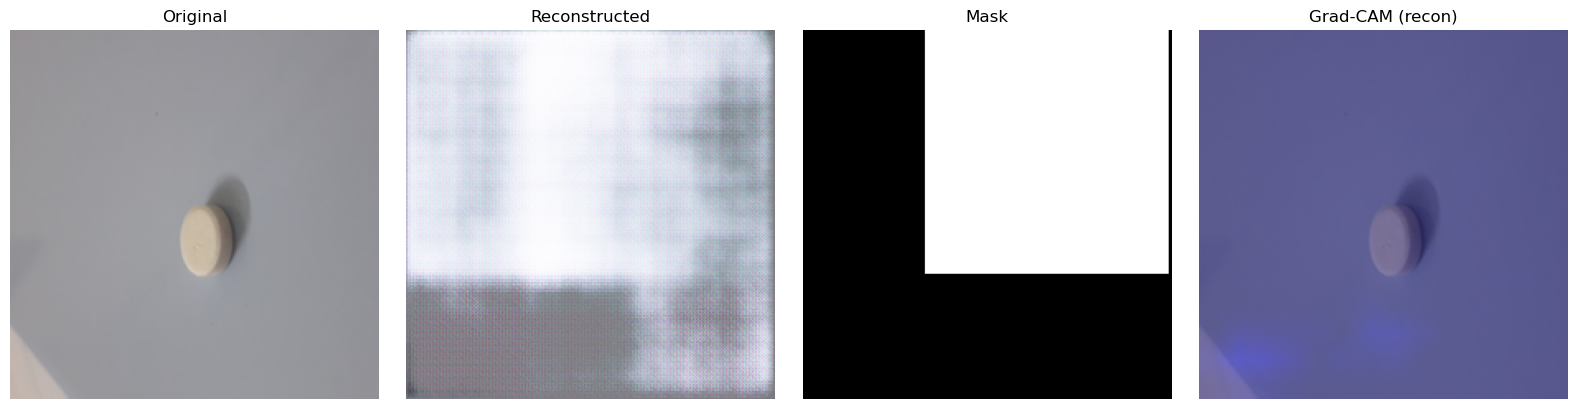

In [20]:
# Load checkpoint and draw Grad-CAM for reconstruction focus
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 1) Load model from specific checkpoint on CPU->device
ckpt_path = "model_checkpoints/checkpoint(split_train)_epoch_10.pth"
model = MaskedAutoencoderSystem(num_classes=NUM_CLASSES).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

# 2) Helper: denormalize to uint8 numpy for plotting
mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)
def to_numpy_image(t):
    x = t.detach().cpu().numpy()
    x = (x * std + mean).clip(0,1)
    x = (x.transpose(1,2,0) * 255).astype(np.uint8)
    return x

# 3) Grad-CAM targeting reconstruction decoder conv (first ConvTranspose)
target_layer = model.rec_head.decoder[1]  # ConvTranspose2d(512->256)

def gradcam_reconstruction(model, images, mask_weighted=True):
    activations = []
    gradients = []
    def fwd_hook(_, __, out):
        activations.append(out)
    def bwd_hook(_, grad_in, grad_out):
        gradients.append(grad_out[0])
    handle_f = target_layer.register_forward_hook(fwd_hook)
    handle_b = target_layer.register_full_backward_hook(bwd_hook)
    model.train()  # need training_mode=True to produce mask/rec branch
    images = images.to(device)
    outputs = model(images, training_mode=True)
    rec_img = outputs["rec_img"]
    mask = outputs["mask"]
    if mask_weighted:
        loss = F.mse_loss(rec_img, images, reduction="none") * mask
        loss = loss.sum() / (mask.sum() + 1e-6)
    else:
        loss = F.mse_loss(rec_img, images)
    loss.backward()
    with torch.no_grad():
        act = activations[0]           # [B, C, H, W]
        grad = gradients[0]            # same shape
        weights = grad.mean(dim=(2,3), keepdim=True)
        cam = (weights * act).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=images.shape[2:], mode="bilinear", align_corners=False)
        cam_min, cam_max = cam.min(), cam.max() + 1e-6
        cam = (cam - cam_min) / cam_max
    handle_f.remove(); handle_b.remove()
    return cam.cpu(), rec_img.detach().cpu(), mask.detach().cpu()

# 4) Run one batch from test_dataloader and visualize first sample
batch = next(iter(test_dataloader))
imgs, labels = batch
cam, rec_out, mask = gradcam_reconstruction(model, imgs, mask_weighted=True)
idx = 0
orig = to_numpy_image(imgs[idx])
rec = (rec_out[idx].numpy().transpose(1,2,0)).clip(0,1) * 255
rec = rec.astype(np.uint8)
cam_map = cam[idx,0].numpy()
mask_map = mask[idx,0].numpy()

# Heatmap overlay
cmap = plt.get_cmap("jet")
heat = cmap(cam_map)[..., :3]
overlay = (0.4 * heat + 0.6 * (orig/255.0)).clip(0,1)

fig, axs = plt.subplots(1,4, figsize=(16,4))
axs[0].imshow(orig)
axs[0].set_title("Original")
axs[1].imshow(rec)
axs[1].set_title("Reconstructed")
axs[2].imshow(mask_map, cmap="gray")
axs[2].set_title("Mask")
axs[3].imshow(overlay)
axs[3].set_title("Grad-CAM (recon)")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

# Clean grads
model.zero_grad()
torch.cuda.empty_cache() if torch.cuda.is_available() else None